In [78]:
# list all files in a directory

import os

pos = []
for file in os.listdir('./aclImdb/train/pos'):
  fd = open(f'./aclImdb/train/pos/{file}')
  x = fd.read()
  pos.append(x)

neg = []
for file in os.listdir('./aclImdb/train/neg'):
  fd = open(f'./aclImdb/train/neg/{file}')
  x = fd.read()
  neg.append(x)

unsup = []
for file in os.listdir('./aclImdb/train/unsup'):
  fd = open(f'./aclImdb/train/unsup/{file}')
  x = fd.read()
  unsup.append(x)

print(len(pos), len(neg), len(unsup))


12500 12500 50000


In [79]:
import pandas as pd

df_pos = pd.DataFrame(pos, columns=['text'])
df_neg = pd.DataFrame(neg, columns=['text'])
df_unsup = pd.DataFrame(unsup, columns=['text'])

df_pos['label'] = 0
df_neg['label'] = 1
df_unsup['label'] = 2

df_pos['set'] = 'train'
df_neg['set'] = 'train'
df_unsup['set'] = 'train'

df = pd.concat([df_pos[0:20], df_neg[0:20], df_unsup[0:20]])
df.head()

,text,label,set
0,For a movie that gets no respect there sure ar...,0,train
1,Bizarre horror movie filled with famous faces ...,0,train
2,"A solid, if unremarkable film. Matthau, as Ein...",0,train
3,It's a strange feeling to sit alone in a theat...,0,train
4,"You probably all already know this by now, but...",0,train


In [80]:
import os
import openai
from dotenv import load_dotenv
load_dotenv()

openai.organization = "org-ITye4e6Cusa0BUGY6ucHrfq3"
openai.api_key = os.getenv("OPENAI_API_KEY")
openai.Model.list()

<OpenAIObject list at 0x7fb7289875e0> JSON: {
  "data": [
    {
      "created": 1649358449,
      "id": "babbage",
      "object": "model",
      "owned_by": "openai",
      "parent": null,
      "permission": [
        {
          "allow_create_engine": false,
          "allow_fine_tuning": false,
          "allow_logprobs": true,
          "allow_sampling": true,
          "allow_search_indices": false,
          "allow_view": true,
          "created": 1669085501,
          "group": null,
          "id": "modelperm-49FUp5v084tBB49tC4z8LPH5",
          "is_blocking": false,
          "object": "model_permission",
          "organization": "*"
        }
      ],
      "root": "babbage"
    },
    {
      "created": 1649880485,
      "id": "code-davinci-002",
      "object": "model",
      "owned_by": "openai",
      "parent": null,
      "permission": [
        {
          "allow_create_engine": false,
          "allow_fine_tuning": false,
          "allow_logprobs": true,
          

In [83]:
print(len(df))

60


In [84]:
# https://github.com/openai/openai-cookbook/blob/main/examples/Embedding_long_inputs.ipynb

from tenacity import retry, wait_random_exponential, stop_after_attempt, retry_if_not_exception_type
import time

EMBEDDING_MODEL = 'text-embedding-ada-002'

count = 0
@retry(
  wait=wait_random_exponential(min=1, max=60), 
  stop=stop_after_attempt(6), 
  retry=retry_if_not_exception_type(openai.InvalidRequestError))
def get_embedding(text_or_tokens, model=EMBEDDING_MODEL):
    res = openai.Embedding.create(input=text_or_tokens, model=model)
    print(count)
    count += 1
    return res['data'][0]


df['embedding'] = df['text'].apply(get_embedding)

RetryError: RetryError[<Future at 0x7fb728b93f10 state=finished raised UnboundLocalError>]

<Axes: ylabel='label'>

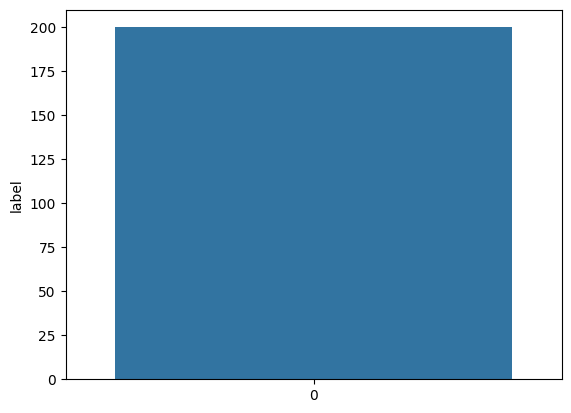

In [77]:
# seaborn bar chart of labels 
import seaborn as sns

sns.barplot(x=df['label'].value_counts().index, y=df['label'].value_counts())

In [ ]:
# tsne plot of embeddings f